In [1]:
#定义一些函数，可用来读取数据以及数据处理
import numpy as np
import cv2
import os
from PIL import Image
#读数据
def read_image_and_name(path):
    imgdir = os.listdir(path)
    imgs = []
    print(path)
    for v in imgdir:
        print(v)
        imgs.append(cv2.imread(path + v))
    print('Original images shape: ' + str(np.array(imgs).shape))
    return imgs
#读标签
def read_label_and_name(path):
    labeldir = os.listdir(path)
    labels = []
    print(path)
    for v in labeldir:
        print(v)
        labels.append(np.asarray(Image.open(path + v)))
    print('Original labels shape: ' + str(np.array(labels).shape))
    return labels
#裁剪为目标大小
def resize(imgs,resize_height, resize_width):
    img_resize = []
    for file in imgs:
        img_resize.append(cv2.resize(file,(resize_height,resize_width)))
    return img_resize
#添加椒盐噪声
def SaltAndPepper(src,percetage):  
    list=[]
    for j in range(src.shape[0]):
        SP_NoiseImg=src[j].copy()
        SP_NoiseNum=int(percetage*src[j].shape[0]*src[j].shape[1]) 
        for i in range(SP_NoiseNum): 
            randR=np.random.randint(0,src[j].shape[0]-1) 
            randG=np.random.randint(0,src[j].shape[1]-1) 
            randB=np.random.randint(0,3)
            if np.random.randint(0,1)==0: 
                SP_NoiseImg[randR,randG,randB]=0 
            else: 
                SP_NoiseImg[randR,randG,randB]=255 
        list.append(src[j])
        list.append(SP_NoiseImg)
    return np.array(list)
#图片旋转
def rotate(image, angle=15, scale=0.9):
    list=[]
    for j in range(image.shape[0]):
        w = image[j].shape[1]
        h = image[j].shape[0]
        #rotate matrix
        M = cv2.getRotationMatrix2D((w/2,h/2), angle, scale)
        #rotate
        image2 = cv2.warpAffine(image[j],M,(w,h))
        list.append(image[j])
        list.append(image2)
    return np.array(list)
#将N张576x576的图片裁剪成目标dx*dx
def crop(image,dx):
    list = []
    for i in range(image.shape[0]):
        for x in range(image.shape[1] // dx):
            for y in range(image.shape[2] // dx):
                list.append(image[ i,  y*dx : (y+1)*dx,  x*dx : (x+1)*dx])
    return np.array(list)
#将1张576x576的图片裁剪成目标dx*dx
def crop1(image,dx):
    list = []
    for x in range(image.shape[0]//dx):
        for y in range(image.shape[1]//dx):
            list.append(image[x*dx:(x+1)*dx, y*dx:(y+1)*dx])
    return (np.array(list)[:,np.newaxis,...])
#DICE评价参数
def dice_coefficient(a,b):
    return 2.*np.sum(a*b)/(np.sum(a)+np.sum(b))

In [2]:
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Reshape, core, Dropout #core内部定义了一系列常用的网络层，包括全连接、激活层等
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
#根据论文定义网络结构
def get_unet(n_ch,patch_height,patch_width):
    inputs = Input(shape=(n_ch,patch_height,patch_width))
    #data_format：字符串，“channels_first”或“channels_last”之一，代表图像的通道维的位置。
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(inputs)
    conv1 = Dropout(0.2)(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    ###
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same',data_format='channels_first')(pool1)
    conv2 = Dropout(0.2)(conv2)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    ###
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same',data_format='channels_first')(pool2)
    conv3 = Dropout(0.2)(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    ###
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same',data_format='channels_first')(pool3)
    conv4 = Dropout(0.2)(conv4)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    ###
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same',data_format='channels_first')(pool4)
    conv5 = Dropout(0.2)(conv5)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv5)
    up1 = UpSampling2D(size=(2, 2))(conv5)
    up1 = concatenate([conv4,up1],axis=1)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same',data_format='channels_first')(up1)
    conv6 = Dropout(0.2)(conv6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv6)
    ###
    up2 = UpSampling2D(size=(2, 2))(conv6)
    up2 = concatenate([conv3,up2], axis=1)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same',data_format='channels_first')(up2)
    conv7 = Dropout(0.2)(conv7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv7)
    ###
    up3 = UpSampling2D(size=(2, 2))(conv7)
    up3 = concatenate([conv2,up3], axis=1)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same',data_format='channels_first')(up3)
    conv8 = Dropout(0.2)(conv8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv8)
    ###
    up4 = UpSampling2D(size=(2, 2))(conv8)
    up4 = concatenate([conv1,up4], axis=1)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(up4)
    conv9 = Dropout(0.2)(conv9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv9)
    ###
    #1×1的卷积大概有两个方面的作用：1. 实现跨通道的交互和信息整合2. 进行卷积核通道数的降维和升维。
    conv10 = Conv2D(2, (1, 1), activation='relu',padding='same',data_format='channels_first')(conv9)
    conv10 = core.Reshape((2,patch_height*patch_width))(conv10)
    conv10 = core.Permute((2,1))(conv10)
    ###
    conv11 = core.Activation('softmax')(conv10)
    model = Model(inputs=inputs, outputs=conv11)
    model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy',metrics=['accuracy'])
    return model
#定义一个优化后的网络
def better_net(n_ch,patch_height,patch_width):
    inputs = Input(shape=(n_ch,patch_height,patch_width))
    #data_format：字符串，“channels_first”或“channels_last”之一，代表图像的通道维的位置。
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(inputs)
    conv1 = Dropout(0.2)(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    ###
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(pool1)
    conv2 = Dropout(0.2)(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    ###
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same',data_format='channels_first')(pool2)
    conv3 = Dropout(0.2)(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    ###
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same',data_format='channels_first')(pool3)
    conv4 = Dropout(0.2)(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv4)
    up1 = UpSampling2D(size=(2, 2))(conv4)
    up1 = concatenate([conv3,up1],axis=1)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same',data_format='channels_first')(up1)
    conv5 = Dropout(0.2)(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv5)    
    ###
    up2 = UpSampling2D(size=(2, 2))(conv5)
    up2 = concatenate([conv2,up2],axis=1)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(up2)
    conv6 = Dropout(0.2)(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv6)    
    ###
    up3 = UpSampling2D(size=(2, 2))(conv6)
    up3 = concatenate([conv1,up3],axis=1)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(up3)
    conv7 = Dropout(0.2)(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv7) 
    pool4 = MaxPooling2D((2, 2))(conv7)
    ###
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(pool4)
    conv8 = Dropout(0.2)(conv8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv8)
    pool5 = MaxPooling2D((2, 2))(conv8)
    ###
    conv9 = Conv2D(128, (3, 3), activation='relu', padding='same',data_format='channels_first')(pool5)
    conv9 = Dropout(0.2)(conv9)
    conv9 = Conv2D(128, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv9)
    pool6 = MaxPooling2D((2, 2))(conv9)
    ###
    conv10 = Conv2D(256, (3, 3), activation='relu', padding='same',data_format='channels_first')(pool6)
    conv10 = Dropout(0.2)(conv10)
    conv10 = Conv2D(256, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv10)
    up4 = UpSampling2D(size=(2, 2))(conv10)
    up4 = concatenate([conv3,up4],axis=1)
    conv11 = Conv2D(128, (3, 3), activation='relu', padding='same',data_format='channels_first')(up4)
    conv11 = Dropout(0.2)(conv11)
    conv11 = Conv2D(128, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv11)    
    ###
    up5 = UpSampling2D(size=(2, 2))(conv11)
    up5 = concatenate([conv2,up5],axis=1)
    conv12 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(up5)
    conv12 = Dropout(0.2)(conv12)
    conv12 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv12)    
    ###
    up6 = UpSampling2D(size=(2, 2))(conv12)
    up6 = concatenate([conv1,up6],axis=1)
    conv13 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(up6)
    conv13 = Dropout(0.2)(conv13)
    conv13 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv13)  
    #1×1的卷积大概有两个方面的作用：1. 实现跨通道的交互和信息整合2. 进行卷积核通道数的降维和升维。
    conv14 = Conv2D(2, (1, 1), activation='relu',padding='same',data_format='channels_first')(conv13)
    conv14 = core.Reshape((2,patch_height*patch_width))(conv14)
    conv14 = core.Permute((2,1))(conv14)
    ###
    conv15 = core.Activation('softmax')(conv14)
    model = Model(inputs=inputs, outputs=conv15)
    model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy',metrics=['accuracy'])
    return model

In [3]:
import keras
import datetime
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.compat.v1 import GPUOptions
#动态分配显存资源
gpu_options = GPUOptions(per_process_gpu_memory_fraction=0.8)#上限90%
config = ConfigProto(gpu_options=gpu_options)
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
#定义数据参数和路径
resize_height, resize_width = (576, 576)
dx = 48
img_path = 'data/train/image/'
label_path = 'data/train/mask/'
#读取数据
images = read_image_and_name(img_path)
labels = read_label_and_name(label_path)
#将imgs列表和label列表裁剪成576*576的统一大小
X_train = np.array(resize(images,resize_height, resize_width))
# print('X_train.shape'+str(X_train.shape))
Y_train = np.array(resize(labels,resize_height, resize_width))
# print('Y_train.shape'+str(Y_train.shape))
#数据标准化/归一化
X_train = X_train.astype('float32')/255
Y_train = Y_train.astype('float32')/255
#图像增强
#旋转，数据量翻一倍
X_train=rotate(X_train,angle=10,scale=1)
# print('X_train.shape:'+str(X_train.shape))
Y_train=rotate(Y_train,angle=10,scale=1)
# print('Y_train.shape:'+str(Y_train.shape))
#增加椒盐噪声，数据量再翻一倍为80张图
X_train=SaltAndPepper(X_train,0.1)
# print('X_train.shape:'+str(X_train.shape))
Y_train=SaltAndPepper(Y_train,0)
# print('Y_train.shape:'+str(Y_train.shape))
#将三通道转换为单通道
X_train_0=X_train[...,0]
# print('X_train_0.shape:'+str(X_train_0.shape))
X_train_1=X_train[...,1]
# print('X_train_1.shape:'+str(X_train_1.shape))
X_train_2=X_train[...,2]
# print('X_train_2.shape:'+str(X_train_2.shape))
#将每个通道进行裁剪，裁剪成dx*dx的许多小块
X_train_0 = crop(X_train_0,dx)
# print('X_train_0.shape:'+str(X_train_0.shape))
X_train_1 = crop(X_train_1,dx)
# print('X_train_1.shape:'+str(X_train_1.shape))
X_train_2 = crop(X_train_2,dx)
# print('X_train_2.shape:'+str(X_train_2.shape))
Y_train = crop(Y_train,dx)
# print('Y_train.shape:'+str(Y_train.shape))
#将三通道进行合并
X_train_0 = X_train_0[:,np.newaxis, ...]
# print('X_train_0.shape:'+str(X_train_0.shape))
X_train_1 = X_train_1[:,np.newaxis, ...]
# print('X_train_1.shape:'+str(X_train_1.shape))
X_train_2 = X_train_2[:,np.newaxis, ...]
# print('X_train_2.shape:'+str(X_train_2.shape))
X_train=np.concatenate((X_train_0,X_train_1,X_train_2),axis=1)
# print('X_train.shape:'+str(X_train.shape))
#将Y_train改为单通道，与图像格式有关
Y_train=Y_train[...,0]
# print('Y_train.shape:'+str(Y_train.shape))
#Y_train改变shape,保持第一维不变，其他维合并
Y_train = Y_train.reshape(Y_train.shape[0],-1)
# print('Y_train shape: '+str(Y_train.shape))
Y_train =Y_train[..., np.newaxis]  #增加一维变成
# print('Y_train shape: '+str(Y_train.shape))
#创建一个互补的Y
temp = 1 - Y_train
#将两个Y合并，用于loss
Y_train = np.concatenate([Y_train, temp], axis=2)
# print('Y_train shape: '+str(Y_train.shape))

data/train/image/
21_training.tif
22_training.tif
23_training.tif
24_training.tif
25_training.tif
26_training.tif
27_training.tif
28_training.tif
29_training.tif
30_training.tif
31_training.tif
32_training.tif
33_training.tif
34_training.tif
35_training.tif
36_training.tif
37_training.tif
38_training.tif
39_training.tif
40_training.tif
Original images shape: (20, 592, 576, 3)
data/train/mask/
21_training.tif
22_training.tif
23_training.tif
24_training.tif
25_training.tif
26_training.tif
27_training.tif
28_training.tif
29_training.tif
30_training.tif
31_training.tif
32_training.tif
33_training.tif
34_training.tif
35_training.tif
36_training.tif
37_training.tif
38_training.tif
39_training.tif
40_training.tif
Original labels shape: (20, 592, 576, 3)


In [4]:
#模型实例化
model = get_unet(X_train.shape[1],X_train.shape[2],X_train.shape[3])
model_better =better_net(X_train.shape[1],X_train.shape[2],X_train.shape[3])
#输出参数Param计算过程
model.summary()
model_better.summary()
#设置保存点，保存效果最好的模型权重
checkpointer = ModelCheckpoint(filepath='./model/best_weights.h5',verbose=1,monitor='val_accuracy',mode='auto',save_best_only=True)
#设置模型参数
model.compile(optimizer=Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])
model_better.compile(optimizer=Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])
#设置tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
#训练模型
model.fit(X_train,Y_train,batch_size=14,epochs=10,verbose=1,shuffle=True,validation_split=0.2,callbacks=[checkpointer,tensorboard_callback])
print('--------原模型训练好了！---------')
model_better.fit(X_train,Y_train,batch_size=14,epochs=10,verbose=1,shuffle=True,validation_split=0.2)
print('--------优化模型训练好了！---------')

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3, 48, 48)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 48, 48)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 64, 48, 48)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 48, 48)   36928       dropout[0][0]                    
_______________________________________________________________________________________

Epoch 1/10
  1/659 [..............................] - ETA: 0s - loss: 0.6948 - accuracy: 0.3072WARNING:tensorflow:From l:\anaconda3\envs\cs286\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
659/659 [==============================] - ETA: 0s - loss: 0.2518 - accuracy: 0.9160
Epoch 00001: val_accuracy improved from -inf to 0.92658, saving model to ./model\best_weights.h5
659/659 [==============================] - 146s 221ms/step - loss: 0.2518 - accuracy: 0.9160 - val_loss: 0.1990 - val_accuracy: 0.9266
Epoch 2/10
659/659 [==============================] - ETA: 0s - loss: 0.1470 - accuracy: 0.9494
Epoch 00002: val_accuracy improved from 0.92658 to 0.96006, saving model to ./model\best_weights.h5
659/659 [==============================] - 136s 206ms/step - loss: 0.1470 - accuracy: 0.9494 - val_loss: 0.1116

In [5]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
#随便读取一张预测图片
imgs = cv2.imread('data/test/images/01_test.tif') 
# 将预测图片裁剪成576*576的大小，和训练时的输入数据统一
imgs = np.array(cv2.resize(imgs,(resize_height,resize_width))) #imgs现在是576x576大小
#读取预测图片的标签
label = np.array(Image.open('data/test/mask/01_test.tif'))
# print(label.shape)
#一样的裁剪
label = np.array(cv2.resize(label,(resize_height, resize_width)))
# print(label.shape)
#预测图片和标签标准化
X_test = imgs.astype('float32')/255
# print('X_test original shape: '+str(X_test.shape))
Y_test = label.astype('float32')
#三通道拆开
X_test_0=X_test[...,0]
X_test_1=X_test[...,1]
X_test_2=X_test[...,2]
#对预测图片进行裁剪
X_test_0=crop1(X_test_0,dx)
X_test_1=crop1(X_test_1,dx)
X_test_2=crop1(X_test_2,dx)
#X_test合并为三通道
X_test=np.concatenate((X_test_0,X_test_1,X_test_2),axis=1)
# print('input shape: '+str(X_test.shape))

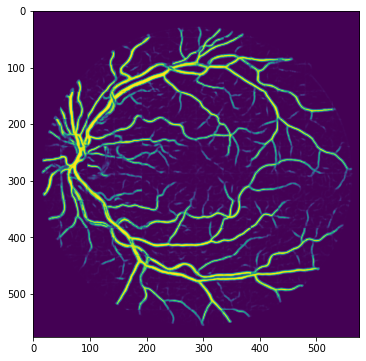

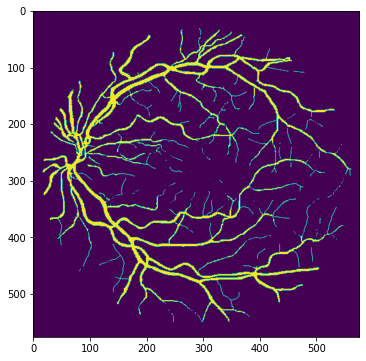

In [6]:
#加载模型和权重
model = get_unet(X_test.shape[1],X_test.shape[2],X_test.shape[3])
model.load_weights('./model/best_weights.h5')
#预测
Y_pred = model.predict(X_test)
Y_pred_better=model_better.predict(X_test)
# print('predict shape: '+str(Y_pred.shape)) #预测结果的shape是(Npatches,patch_height*patch_width,2)
#把预测输出的numpy数组拼接还原再显示
Y_pred = Y_pred[..., 0]
Y_pred_better = Y_pred_better[..., 0]
#把预测结果拼接成(576,576)
t=0
image = np.zeros((resize_height,resize_width))
image_better = np.zeros((resize_height,resize_width))
for i in range(resize_height//dx):
    for j in range(resize_width//dx):
        temp = Y_pred[t].reshape(dx,dx)
        image[i*dx:(i+1)*dx, j*dx:(j+1)*dx] = temp
        temp_better = Y_pred_better[t].reshape(dx,dx)
        image_better[i*dx:(i+1)*dx, j*dx:(j+1)*dx] = temp_better
        t = t+1
# 画图
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.figure(figsize=(6, 6))
plt.imshow(Y_test)
plt.show()

In [12]:
# 内嵌tensorboard，如果报错或者无法显示，重新运行这个块即可
#肯定可以运行的！！！！只是有的时候不工作！！会拒绝请求！！助教不要把这个的分数扣了！！！
# %load_ext tensorboard
from tensorboard import notebook
%reload_ext tensorboard
notebook.list()
notebook.start("--logdir ./logs/fit")
# %tensorboard --logdir=logs/fit --host=127.0.0.1

Known TensorBoard instances:
  - port 6006: logdir log/validation (started 5 days, 5:36:09 ago; pid 12564)
  - port 6006: logdir log/fit (started 5 days, 5:44:08 ago; pid 12596)
  - port 6006: logdir logs/fit (started 5 days, 5:54:19 ago; pid 16424)
  - port 6006: logdir log (started 5 days, 5:41:10 ago; pid 17384)
  - port 6006: logdir logs/fit (started 1 day, 6:24:10 ago; pid 18796)
  - port 6006: logdir ./log (started 5 days, 5:39:46 ago; pid 24116)
  - port 6006: logdir logs/fit (started 1 day, 15:22:54 ago; pid 24124)
  - port 6006: logdir ./logs/fit (started 21:45:03 ago; pid 25084)
  - port 6006: logdir logs/fit (started 5 days, 5:24:54 ago; pid 6432)


Reusing TensorBoard on port 6006 (pid 25084), started 21:45:03 ago. (Use '!kill 25084' to kill it.)

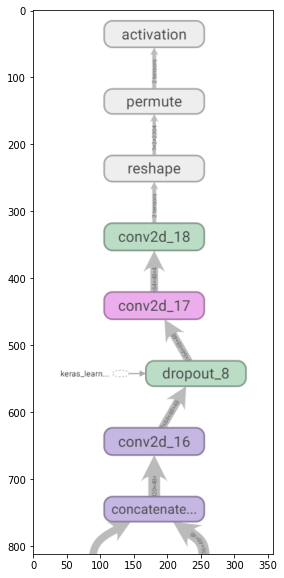

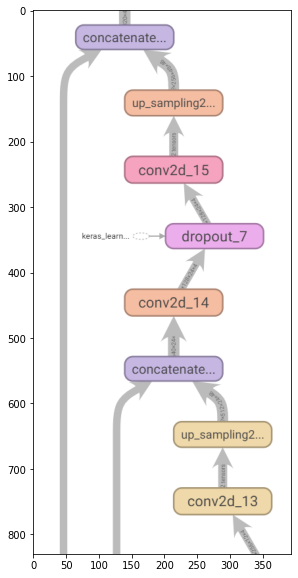

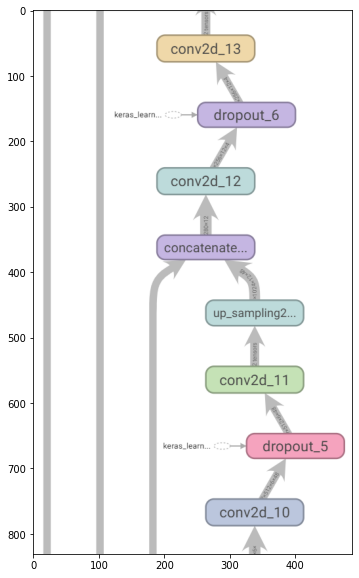

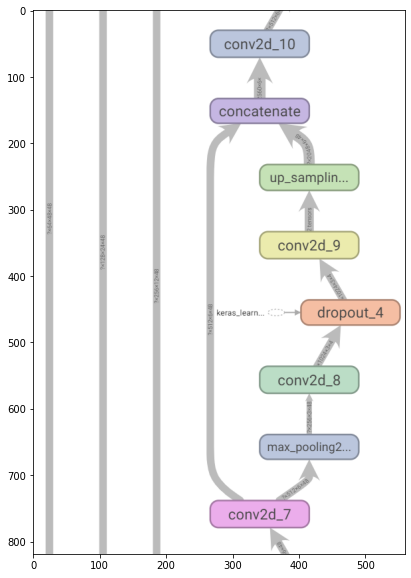

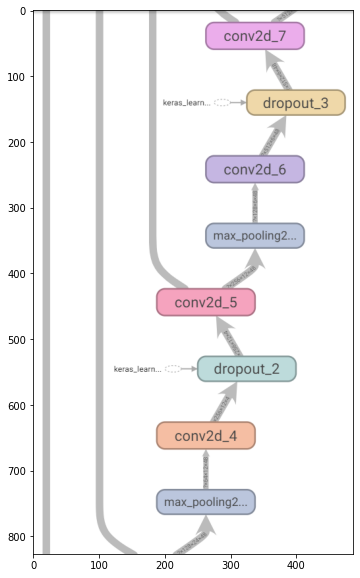

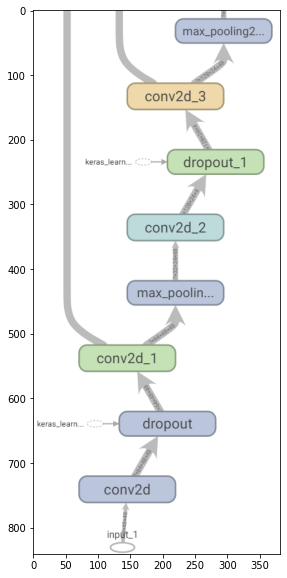

In [8]:
#展示几张训练成功时tensorboard显示的截图
graph=plt.imread('1.png')
plt.figure(figsize=(10, 10))
plt.imshow(graph)
graph=plt.imread('2.png')
plt.figure(figsize=(10, 10))
plt.imshow(graph)
graph=plt.imread('3.png')
plt.figure(figsize=(10, 10))
plt.imshow(graph)
graph=plt.imread('4.png')
plt.figure(figsize=(10, 10))
plt.imshow(graph)
graph=plt.imread('5.png')
plt.figure(figsize=(10, 10))
plt.imshow(graph)
graph=plt.imread('6.png')
plt.figure(figsize=(10, 10))
plt.imshow(graph)
plt.show()

In [9]:
# 所需展示的参数
dice =dice_coefficient(image,Y_test)
dice_better=dice_coefficient(image_better,Y_test)
iou=dice/(2-dice)
print('DICE:',dice)
print('betterDICE:',dice_better)
print('IOU:',iou)

DICE: 0.6995076895535105
betterDICE: 0.710741914720719
IOU: 0.5378791431018558


In [10]:
# 计算ASSD
import numpy as np
from scipy.ndimage import morphology
def surfd(input1, input2, sampling=1, connectivity=1):
    input_1 = np.atleast_1d(input1.astype(np.bool))
    input_2 = np.atleast_1d(input2.astype(np.bool))
    conn = morphology.generate_binary_structure(input_1.ndim, connectivity)
    S = (input_1.astype('uint8') - (morphology.binary_erosion(input_1, conn).astype('uint8'))).astype('bool')
    Sprime = (input_2.astype('uint8') - (morphology.binary_erosion(input_2, conn))).astype('uint8')
    dta = morphology.distance_transform_edt(~S,sampling)
    dtb = morphology.distance_transform_edt(~Sprime,sampling)
    sds = np.concatenate([np.ravel(dta[Sprime!=0]), np.ravel(dtb[S!=0])])
    return sds
assd=np.mean(surfd(image,Y_test,sampling=1, connectivity=1))
print('ASSD:',assd)

ASSD: 169.46576394623958


In [11]:
a=model.predict(X_test)
a.shape

(144, 2304, 2)